# Trying out an LSTM setup
## Using generated data
### Bi-directional LSTM with adversarial softmax layer

In [ ]:
import numpy as np
import gym


def pendulum(observation):
        x, y, angle_velocity = observation
        flip = (y < 0.)
        if flip:
            y *= -1. # now y >= 0
            angle_velocity *= -1.
        angle = np.arcsin(y)
        if x < 0.:
            angle = np.pi - angle
        if (angle < -0.3 * angle_velocity) or \
                (angle > 0.03 * (angle_velocity - 2.5) ** 2. + 1. and \
                angle < 0.15 * (angle_velocity + 3.) ** 2. + 2.):
            force = 2.
        else:
            force = -2.
        if flip:
            force *= -1.
        action = np.array([force,])
        return action

def mountain_car_continuous(observation):
        position, velocity = observation
        if position > -4 * velocity or position < 13 * velocity - 0.6:
            force = 1.
        else:
            force = -1.
        action = np.array([force,])
        return action
    
    
def lunar_lander(observation):
        x, y, v_x, v_y, angle, v_angle, contact_left, contact_right = observation

        if contact_left or contact_right: # legs have contact
            f_y = -10. * v_y - 1.
            f_angle = 0.
        else:
            f_y = 5.5 * np.abs(x) - 10. * y - 10. * v_y - 1.
            f_angle = -np.clip(5. * x + 10. * v_x, -4, 4) + 10. * angle + 20. * v_angle

        if np.abs(f_angle) <= 1 and f_y <= 0:
            action = 0 # do nothing
        elif np.abs(f_angle) < f_y:
            action = 2 # main engine
        elif f_angle < 0.:
            action = 1 # left engine
        else:
            action = 3 # right engine
        return action

def acrobot(observation):
        x0, y0, x1, y1, v0, v1 = observation
        if v1 < -0.3:
            action = 0
        elif v1 > 0.3:
            action = 2
        else:
            y = y1 + x0 * y1 + x1 * y0
            if y > 0.:
                action = 0
            else:
                action = 2
        return action


def lunar_lander_continuous(observation):
        x, y, v_x, v_y, angle, v_angle, contact_left, contact_right = observation

        if contact_left or contact_right:
            f_y = -10. * v_y - 1.
            f_angle = 0.
        else:
            f_y = 5.5 * np.abs(x) - 10. * y - 10. * v_y - 1.
            f_angle = -np.clip(5. * x + 10. * v_x, -4, 4) + 10. * angle + 20. * v_angle

        action = np.array([f_y, f_angle])
        return action
    
    
def cart_pole(observation):
        
        position, velocity, angle, angle_velocity = observation
        action = int(3. * angle + angle_velocity > 0.)
        return action
        
def mountain_car(observation):

    position, velocity = observation
    lb = min(-0.09 * (position + 0.25) ** 2 + 0.03,
            0.3 * (position + 0.9) ** 4 - 0.008)
    ub = -0.07 * (position + 0.38) ** 2 + 0.07
    end = position > 0.2 and velocity > 0.02
    hard_end = position > 0.45
    begin = position < -0.45 and velocity < 0.001 and velocity > -0.001
    if begin or (lb < velocity < ub) or end or hard_end:
        action = 2 
    else:
        action = 0
    return action

class Expert(object):
        
    
    def __init__(self, env_name):
        
        policies = {
            'CartPole-v0': cart_pole,
            'MountainCar-v0': mountain_car,
            'LunarLanderContinuous-v2': lunar_lander_continuous,
            'Acrobot-v1': acrobot,
            'LunarLander-v2': lunar_lander,
            'MountainCarContinuous-v0': mountain_car_continuous,
            'Pendulum-v0': pendulum
        }
        self.env_name = env_name
        self.env = gym.make(self.env_name)
        self.policy = policies[env_name]
        
    def generate_data(self, num_episodes=1):

        trajectories = []
        rewards = []
        splits = []
        counter = 0
        for i in range(num_episodes):


            observation = self.env.reset()
            done = False
            rd = 0
            
            while not done:

                action = self.policy(observation)
                trajectories.append(
                    [
                        feature for feature in observation
                    ] + [action] + [i]
                )
                observation, reward, done, _ = self.env.step(action)
                rd += reward
                counter += 1
            
            rewards.append(rd)
            splits.append(counter)
                
        return np.array(trajectories), np.array(rewards), splits

In [ ]:
!pip install swiglpk # needed to build Box2D in the pip install
!pip install box2d-py 

### Generate data

In [ ]:

expert = Expert('LunarLander-v2')
NUMBER_OF_EPISODES = 10
data, reward , splits = expert.generate_data(NUMBER_OF_EPISODES)
np.mean(reward), np.std(reward)

(280.2495368002873, 20.612315283640907)

In [ ]:
np.unique(data[:,6])

array([0., 1.])


### Plot expert data

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
colors = np.array(['red', 'green', 'blue'])
palette = colors[np.unique(data[:,]).astype(int)].tolist()

fig, ax = plt.subplots(figsize=(10, 7))
_ = sns.scatterplot(x=data[:,0], y=data[:,1], hue=data[:,4], palette=palette)

IndexError: ignored

### Preprocess data into sequences

In [ ]:
X_partitioned = np.split(data, splits)[0:-1]
max_len = np.max([len(x) for x in X_partitioned])
for i in range(len(X_partitioned)):

  for j in range(len(X_partitioned[i])):

    X_partitioned.append(X_partitioned[i][0:j])

X_partitioned_test = np.split(data, splits)[0:-1]

In [ ]:
import torch
torch.cuda.CUDA_LAUNCH_BLOCKING=1
device = torch.device('cuda:0')

In [ ]:
def seq_to_x(seq, pad_to):
    
    return [
            [seq[i][0], seq[i][1],  int(i==0), 0] if i < len(seq)
            else [99, 99,  0, 1]
            for i in range(pad_to)
        ]

def seq_to_target(seq, pad_to):
    
    return [
            seq[i][8] if i < len(seq) else 1 for i in range(pad_to)
        ]


def training_X(data, max_len):
    
    return torch.tensor(
        np.array(
            [
                seq_to_x(seq, max_len) for seq in data
            ],
            dtype=np.float
        ),
        dtype=torch.float
    )

def training_Y(data, max_len):
    
    return torch.tensor(
        [
            seq_to_target(seq, max_len) for seq in data
        ],
        dtype=torch.long
    )

def true_indicies(Y):
    
    true = []
    for i in range(Y.shape[0]):
        
        if Y[i] == 0 or Y[i] == 2:
            true.append(i)
    
    return true

In [ ]:
X = training_X(X_partitioned, max_len)
X_test = training_X(X_partitioned_test, max_len)
X.view(-1, 2).shape
torch.save(X, 'X_train.pt')
x_ids = [i for i in range(len(X))]

In [ ]:
Y = torch.unsqueeze(training_Y(X_partitioned, max_len), dim=2)
Y_test = training_Y(X_partitioned_test, max_len)
true = true_indicies(Y_test.view(-1))
torch.save(Y, 'Y_train.pt')

In [ ]:
class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, list_IDs, labels):
        'Initialization'
        self.labels = labels
        self.list_IDs = list_IDs

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.list_IDs[index]

        # Load data and get label
        X = torch.load('X_train/'+ID + '.pt')
        y = self.labels[ID]

        return X, y

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class PolicyLSTM(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, target_size):
        
        super(PolicyLSTM, self).__init__()
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, bias=True, batch_first=True, bidirectional=True)
        
        self.linear = nn.Linear(hidden_dim*2, target_size)
        
        self.output = nn.LogSoftmax(dim=2)
        
    def forward(self, batch):
        
        lstm_out, _ = self.lstm(batch)
        #print(lstm_out.shape)
        linear_out = self.linear(lstm_out)
        #print(linear_out.shape)
        out = self.output(linear_out)
        #print(out.shape)
        return out
    
    def predict(self, X):
        
        with torch.no_grad():
            pred = self.forward(X)
        
        return torch.argmax(pred, dim=2).view(-1)

model = PolicyLSTM(10, 225, 3).to(device)

In [ ]:
def train(xdata, ydata, model, n_epochs, lr=0.01, print_every=100):
    '''Train the neural model with the given training data'''


    params = {'batch_size': 64,
          'shuffle': True}

    # Datasets
    ids = xdata
    labels = ydata

    # Generators
    training_set = Dataset(ids, labels)
    training_generator = torch.utils.data.DataLoader(training_set, **params)

    criterion = torch.nn.NLLLoss()

    optimizer = torch.optim.SGD(model.parameters(), lr = lr) 


    for epoch in range(n_epochs):
        

        for local_batch, local_labels in training_generator:
          # Transfer to GPU
          local_batch, local_labels = local_batch.to(device), local_labels.to(device)
          model.zero_grad()
        
          Y_pred = model(local_batch)
        
          #print(ydata[99])
          loss = criterion(Y_pred.view(-1, 3), local_labels.view(-1))

        
          if epoch % print_every == 0: print('epoch: ', epoch,' loss: ', loss.item()) 
          if loss.item() < 0.1: lr = 0.001
          if loss.item() < 0.075: lr = 0.0005
          loss.backward()

          optimizer.step()
        
    return model

In [ ]:
train(x_ids, Y, model, 25000, lr=0.01, print_every=1000)

TypeError: ignored

In [ ]:
crit = torch.nn.NLLLoss()
crit(model.forward(X).view(-1, 3), Y.view(-1))
#model.predict(X).shape, Y.view(-1).shape

tensor(0.0145, device='cuda:0', grad_fn=<NllLossBackward>)

In [ ]:
preds = model.predict(X_test)[true].cpu()
preds

tensor([2, 2, 2,  ..., 0, 0, 0])

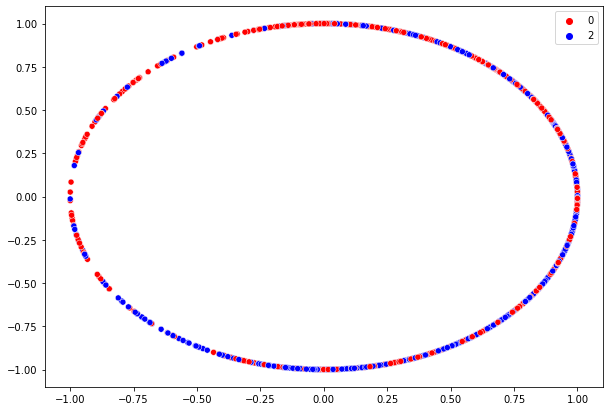

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))
_ = sns.scatterplot(x=data[:,0], y=data[:,1], hue=preds, palette=['red',  'blue'])

In [ ]:
env = gym.make('Acrobot-v1')
rewards = []


for i in range(20):

  #print(i)
  observation = env.reset()
  done = False
  rd = 0
  traj = torch.tensor([[1000, 1000, 1000, 1000, 1000, 1000, 0, 1] for i in range(200)], dtype=torch.float).to(device).unsqueeze(0)
  while not done:
    
    traj[0][-rd] = torch.tensor([ob for ob in observation] + [int(rd==0)] + [0]).to(device)
    action = model.predict(traj)
    #print(action, expert.policy(observation), -rd)
    observation, reward, done, _ = env.step(int(action[-rd].item()))
    rd += int(reward)

  rewards.append(rd)

np.mean(rewards), np.std(rewards)

(-88.05, 25.86595252450603)

In [ ]:
rewards[0]

-99

In [ ]:
torch.save(model, 'bi-directional_lstm')

In [ ]:
import os 
dir_path = os.getcwd()

In [ ]:
dir_path

'/content'

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!ls /content/gdrive/MyDrive/

'2.8 Gerard Jones Response.gdoc'
 444
'4kKpJhOzSbOsyRtAIe4l_NACO TACO TRILLIUM MENU 6.25.20.pdf'
'5 Quotes.gdoc'
'basic concepts 1.pdf'
'basic concepts 2.pdf'
'basic concepts 3.pdf'
'BJs accounting.gsheet'
'BRANDS EXPRESS -- Non Compete and Non Solicitation Agreement.docx'
 Brendan_Crowe_Math_739_Basic_Concepts.pdf
'BrendanCrowe PAWS Fall 2017 Form.pdf'
"Brendan Crowe's Speech.gdoc"
"Brendan Crowe's Time Management .gdoc"
'Brendan Crowe Zoom confirmation.gdoc'
'Colab Notebooks'
'Computer Exercice 6.gdoc'
'Computer Exercise 0.gdoc'
'Computer Exercise 1.gdoc'
'Computer Exercise 3.gdoc'
'Computer Exercise 4.gdoc'
'Computer Exercise 5.gdoc'
'Computer Exercise 7.gdoc'
'Computer Exercise 8.gdoc'
'Computer exerice 13.gdoc'
'Computer Exerice 2.gdoc'
'Copy of 06 ALG_REC_2 - control flow, tail recursion, & backtracking (Student).gdoc'
'Copy of 07 ALG_ANA - algorithm analysis (Student).gdoc'
'Copy of 09 ALG_LIST - Lists & Linked Lists (Student).gdoc'
'Copy of 12 ALG_MAP - Maps (Student).gdoc'
'Co

In [ ]:
!ls

bi-directional_lstm  gdrive  sample_data


In [ ]:
model_save_name = 'bi-directional_lstm.pt'
path = F'/content/gdrive/MyDrive/CS780/final_project/{model_save_name}'
torch.save(model.cpu(), path)

In [ ]:
import pickle

pickle.format_version

'4.0'

In [ ]:
import torch
torch.save(model.cpu().state_dict(), '/content/gdrive/MyDrive/CS780/final_project/acrobot.pt')